## Real-Time Deep Learning Based Human Blink Detection (Worklet -3) 

**Importing Packages**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.preprocessing import image_dataset_from_directory

**Defining the Train, Validate and Test dataset path**

In [ ]:
train_path = '/content/drive/My Drive/Dataset cropped/Train'
valid_path = '/content/drive/My Drive/Dataset cropped/Validate'
test_path = '/content/drive/My Drive/Dataset cropped/Test'

**Image Preparation**

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(train_path, target_size=(224,224), classes=['Open', 'PartiallyOpen','Closed'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), classes=['Open', 'PartiallyOpen','Closed'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(test_path, target_size=(224,224), classes=['Open', 'PartiallyOpen','Closed'], batch_size=10,shuffle=False)

Found 1309 images belonging to 3 classes.
Found 342 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


**Load original MobileNet v2 model**

In [ ]:
mobile =tf.keras.applications.mobilenet_v2.MobileNetV2()
mobile.summary()

14540800/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

**Modifying the Model**

In [ ]:
x=mobile.layers[-2].output
predictions=Dense(3,activation='softmax')(x)
model=tf.keras.Model(inputs=mobile.input,outputs=predictions)

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

**Re-Training the last 5 layers of the model:**

In [ ]:
for layer in model.layers[:-5]:
  layer.trainable=False

**Train the Model**

In [ ]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs = 250
steps_per_epoch = 32
validation_steps = 32

history = model.fit_generator(train_batches,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_batches,
                              validation_steps=validation_steps)

Epoch 1/250
32/32 [==============================] - 4s 139ms/step - loss: 0.5046 - accuracy: 0.6250 - val_loss: 0.5434 - val_accuracy: 0.5400
Epoch 2/250
32/32 [==============================] - 3s 100ms/step - loss: 0.4871 - accuracy: 0.6489 - val_loss: 0.5943 - val_accuracy: 0.4800
Epoch 3/250
32/32 [==============================] - 3s 106ms/step - loss: 0.4207 - accuracy: 0.7125 - val_loss: 0.5119 - val_accuracy: 0.6500
Epoch 4/250
32/32 [==============================] - 3s 108ms/step - loss: 0.3954 - accuracy: 0.7437 - val_loss: 0.4773 - val_accuracy: 0.6400
Epoch 5/250
32/32 [==============================] - 3s 108ms/step - loss: 0.4181 - accuracy: 0.7406 - val_loss: 0.4797 - val_accuracy: 0.6700
Epoch 6/250
32/32 [==============================] - 3s 107ms/step - loss: 0.3982 - accuracy: 0.7429 - val_loss: 0.4424 - val_accuracy: 0.7100
Epoch 7/250
32/32 [==============================] - 3s 100ms/step - loss: 0.3719 - accuracy: 0.7406 - val_loss: 0.4499 - val_accuracy: 0.6900

**Predicting the Eye State**

In [ ]:
test_labels=test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
test_batches.class_indices

{'Closed': 2, 'Open': 0, 'PartiallyOpen': 1}

In [ ]:
predictions=model.predict_generator(test_batches,steps=16.8,verbose=0)

Instructions for updating:
Please use Model.predict, which supports generators.


**CONFUSION MATRIX to check the performance of the Classifier**

In [ ]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[54  3  0]
 [ 6 41  3]
 [ 0  6 55]]


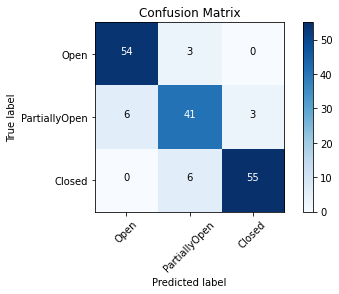

In [ ]:
cm_plot_labels=['Open','PartiallyOpen','Closed']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

**Plots for Training and Validation Accuracy and Loss**

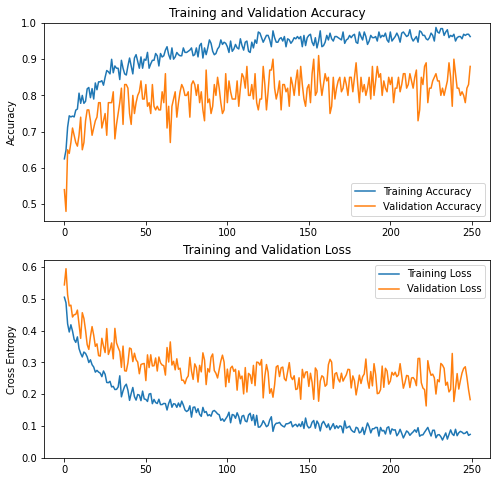

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**Test Accuracy**

In [ ]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

17/17 [==============================] - 2s 106ms/step - loss: 0.2117 - accuracy: 0.8929
Test accuracy : 0.8928571343421936


**Saving the model**

In [ ]:
%cd /content/drive/My Drive/Dataset cropped

/content/drive/My Drive/Dataset cropped


In [ ]:
model.save('Revised_model.h5') 

In [ ]:
model.save('Revised_model') 

INFO:tensorflow:Assets written to: Revised_model/assets


**Combining the Detector and Classifier**

In [ ]:
%cd /content/drive/My Drive/Dataset cropped/Eye_extractor

/content/drive/My Drive/Dataset cropped/Eye_extractor


In [ ]:
!pip install -r req.txt

     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 100.2MB 77kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=dac2a34bf19fdfc750440a8f7404c232ce200f4ee381d91b033fb2fef8dcc34d
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


**Loading the eye extractor and classifier for Images**

In [ ]:
!python3 ExtractEyesfromImages.py

2020-09-01 08:08:54.319717: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-01 08:08:56.074178: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-01 08:08:56.100861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-01 08:08:56.101493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-09-01 08:08:56.101543: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-01 08:08:56.101608: I tensorflow/stream_executor/platform/defaul

**Loading the eye extractor and classifier for Videos**

In [ ]:
!python3 ExtractEyesfromVideoandSave.py

2020-08-31 18:09:24.994331: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-31 18:09:29.627073: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-31 18:09:29.630291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-31 18:09:29.630939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-08-31 18:09:29.630994: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-31 18:09:29.631069: I tensorflow/stream_executor/platform/defa